In [21]:
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, TimeDistributed, Dropout, add, Concatenate, Reshape, RepeatVector, Activation
from tensorflow.keras.optimizers import RMSprop

## **Step 1&2 : Dataset Preparation, Convolution Neural Network (ResNet)**

* ### Creating variables to store the dataset path (images and captions).

In [22]:
Path = '/kaggle/input/flickr8k'
myPath = '/kaggle/working'
images_path = "Images"
captions_path = "captions.txt"
training_data = []
eval_data = []
test_data = []

## 1. Load Images:
* Load, resize and normalize the images to a suitable format that can be efficiently processed by the CNN model.

In [23]:
def preprocess(image_path):
  im = load_img(image_path, target_size=(224,224))
  im = img_to_array(im)
  im = np.expand_dims(im, axis=0)
  return im

#try the function

im_path = Path + '/' + images_path + '/1000268201_693b08cb0e.jpg'
im = preprocess(im_path)
im

array([[[[ 56.,  55.,  73.],
         [106., 123., 117.],
         [129., 149., 138.],
         ...,
         [  5.,   0.,   4.],
         [  5.,   5.,   5.],
         [  3.,   8.,   2.]],

        [[ 51.,  48.,  67.],
         [110., 126., 125.],
         [132., 154., 142.],
         ...,
         [ 10.,  12.,   9.],
         [  7.,   8.,  10.],
         [ 21.,  30.,  13.]],

        [[ 47.,  42.,  64.],
         [114., 130., 130.],
         [130., 153., 145.],
         ...,
         [  8.,   9.,   4.],
         [  2.,   9.,   2.],
         [  0.,  15.,   8.]],

        ...,

        [[231., 173.,  76.],
         [144.,  67.,  11.],
         [159., 103.,  54.],
         ...,
         [250., 249., 254.],
         [164., 185., 204.],
         [163., 185., 199.]],

        [[169.,  90.,  13.],
         [143.,  86.,  15.],
         [217., 153.,  56.],
         ...,
         [244., 240., 255.],
         [172., 185., 204.],
         [168., 185., 195.]],

        [[187.,  88.,  31.],
       

* ### loading the images and creating features dictionary {image_id : features_vector}

In [25]:
# from sklearn.preprocessing import StandardScaler
# features = {}
# directory = os.path.join(Path, 'Images')
# for img_name in tqdm(os.listdir(directory)):
#     img_path = directory + '/' + img_name
#     image = preprocess_input(preprocess(img_path))
#     feature = model.predict(image)
#     image_id = img_name.split('.')[0]
#     features[image_id] = feature

> ### storing the features dictionary into a file avoiding rerunning again

In [26]:
# import pickle
# pickle.dump(features, open(os.path.join(myPath, 'features.pkl'), 'wb'))

> ### loading the features dictionary from previously stored file avoiding rerunning again

In [27]:
import pickle
with open(os.path.join(myPath, 'features.pkl'), 'rb') as features_file:
  features = pickle.load(features_file)

### Check for the shape of features vector.

In [28]:
# for key in features.keys():
#     features[key] = features[key].reshape(2048)

In [29]:
features['3226254560_2f8ac147ea'][0].shape

(2048,)

> ## load captions

In [30]:
with open(os.path.join(Path, 'captions.txt'), 'r') as captions_file:
  next(captions_file)
  caps = captions_file.read()

> ### **<**image,caption**>** dictionary creation

In [31]:
map_caps = {}
for caption in tqdm(caps.split('\n')):
  tokens = caption.split(',')# [image name, caption#]
  if(len(caption)<2):# if length of caption is less than 2 (i.e. not <img, caption> pair then continue)
    continue
  im_id, im_caption = tokens[0], tokens[1:]# image with its caption(s)
  im_id = im_id.split('.')[0]# remove .jpg
  im_caption = " ".join(im_caption)#convert the captions list to string.
  if(im_id not in map_caps):# create list of captions
    map_caps[im_id] = []
  map_caps[im_id].append(im_caption)# append caption# to the image's captions list

100%|██████████| 40456/40456 [00:00<00:00, 364480.79it/s]


> ### Removing any special character, replacing multi-spaces to a single one and Add start and end tags to each caption

In [32]:
def adjust_captions(map_caps):
  for key, captions in map_caps.items():
    for i in range(len(captions)):
      caption = captions[i] 
      caption = caption.lower()
      caption = caption.replace('[^A-Za-z]','')
      caption = caption.replace('\s+',' ')
      caption = 'start ' + ' '.join([word for word in caption.split() if len(word)>1]) + ' end'
      captions[i] = caption

In [33]:
adjust_captions(map_caps)
map_caps['1000268201_693b08cb0e']

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end']

In [34]:
total_captions = []
for key in map_caps:
  for caption in map_caps[key]:
    total_captions.append(caption)

len(total_captions)

40455

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(total_captions)
unique_vocab_size = len(tokenizer.word_index) + 1
unique_vocab_size

8483

In [36]:
# get the max length
max_len = max(len(caption.split()) for caption in total_captions)
max_len

35

In [37]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield ({"image": X1, "text": X2}, y)
                X1, X2, y = list(), list(), list()
                n = 0



## **Step 3: Recurrent Neural Network (LSTM)**

## Splitting the dataset into:
*  Training set (6091 element)
*  Validation set (1000 element)
*  Test set (1000 element)

In [39]:

image_ids = list(map_caps.keys())

training_data = image_ids[:6091]
validation_data = image_ids[6091:7091]
test_data = image_ids[7091:8091]


print(len(training_data))
print(len(validation_data))
print(len(test_data))

6091
1000
1000


In [42]:
print("Training Accuracy: ",hist.history['accuracy'][-1])

Training Accuracy:  0.5143548846244812


### Saving the results of model training on a file to be easily restore the training status with out rerunning the code.

In [43]:
model.save(myPath + '/model_weights.h5')

## **Step 5: Caption Generation**

### The following function used to convert the index generated by tokenizer -existed in unique vocabulary set- into the corresponding word.

In [44]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [45]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'start'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'end':
            break
      
    return in_text

In [46]:
from nltk.translate.bleu_score import corpus_bleu
# validate with validation data
actual, predicted = list(), list()

for key in tqdm(validation_data):
    # get actual caption
    captions = map_caps[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_len) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 1000/1000 [10:57<00:00,  1.52it/s]


BLEU-1: 0.462755
BLEU-2: 0.240648


In [47]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = map_caps[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_len) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 1000/1000 [10:57<00:00,  1.52it/s]


BLEU-1: 0.474981
BLEU-2: 0.254419


In [48]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(Path, "Images", image_name)
    image = Image.open(img_path)
    captions = map_caps[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_len)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

> ## Showcase examples from the test set where the model performs well.

---------------------Actual---------------------
start girl is climbing rock while someone is filming her end
start little girl is climbing up rock as her mom 's shadow is casting over the rock end
start small child climbs large rock while someone casting shadow takes her picture end
start young girl is rock climbing end
start the long black shadow casts image on the rock while the young girl climbs the rock end
--------------------Predicted--------------------
start climber climbs rock wall end


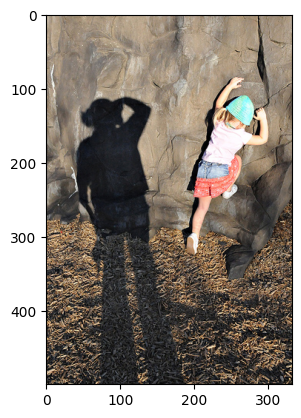

In [50]:
test_img = '2208067635_39a03834ca.jpg'
generate_caption(test_img)

---------------------Actual---------------------
start boy sitting in water end
start small boy is sitting in the water and water is splashing up through his legs end
start young boy in swimming suit sits in water end
start young boy sitting on water jet in pool end
start little boy sitting in water with fountain coming up through his lap end
--------------------Predicted--------------------
start boy in swimming pool end


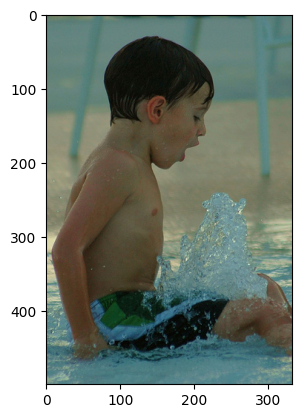

In [ ]:
generate_caption("1287475186_2dee85f1a5.jpg")

---------------------Actual---------------------
start black and white dog on the snow end
start black dog and white dog are standing on snow end
start "two dogs one black and one white face the camera in field of snow ." end
start two dogs standing in the snow end
start two dogs stand in the snow end
--------------------Predicted--------------------
start dog is running through the snow end


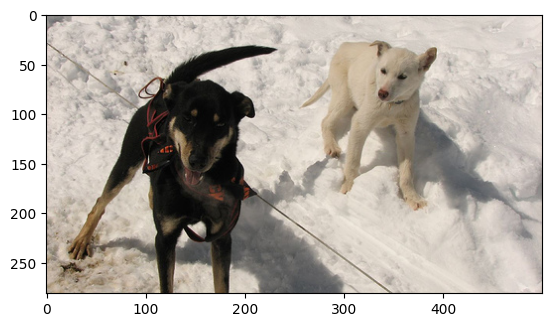

In [52]:
generate_caption("1287931016_fb015e2e10.jpg")

> ## Highlight instances where the model performs poorly and analyze the reasons behind it.

---------------------Actual---------------------
start boy with his mouth open and tongue sticking out clinging to bar next to platform end
start chidl climbs latter as he sticks out his tongue end
start small boy climbing backyard play set end
start young boy with his tongue stuck out is climbing onto wooden platform end
start the boy is climbing end
--------------------Predicted--------------------
start boy wearing red shirt climbs on playground end


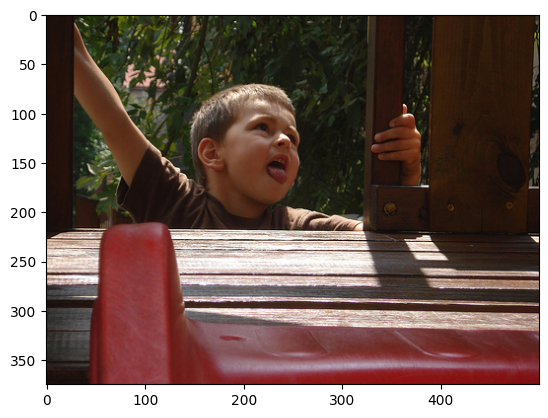

In [53]:
generate_caption("1286408831_05282582ed.jpg")

---------------------Actual---------------------
start winter landscape with four people walking in the snow end
start beautiful snowy landscape with people treading through the snow end
start cross-country skiers are traveling towards the mountains at sunset end
start four people walking across thick snow during sunset end
start the sun is almost behind the snowy mountains end
--------------------Predicted--------------------
start the sun is almost behind the sun at dog on snowy plain end


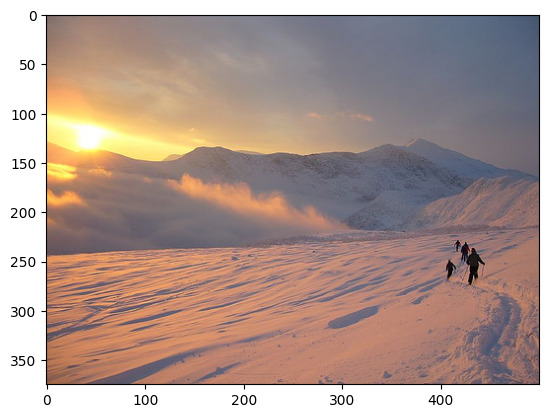

In [54]:
generate_caption("127450902_533ceeddfc.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'start dog is running through the woods end'

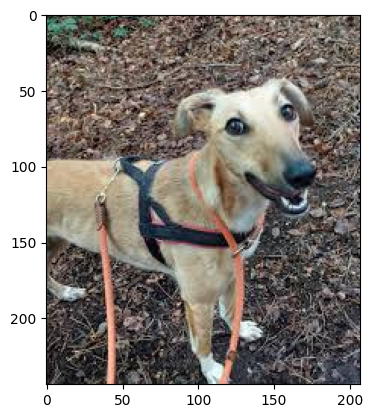

In [64]:
img_path = '/kaggle/input/catcat/test/dogs/dog_114.jpg'
image = Image.open(img_path)
plt.imshow(image)
img = preprocess_input(preprocess(img_path))
feature = resnet_model.predict(img)
predict_caption(model, feature, tokenizer, max_len)